# End to end examples

## Breast Cancer Wisconsin(Diagnostic)

In [1]:
using Pkg; Pkg.activate("D:/JULIA/6_ML_with_Julia/EX-breastcancer"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\EX-breastcancer`


> Introduction <br>
> Loading the relevant packages <br>
> Downloading and loading the data <br>
> Exploring the obtained data <br>
> 1. Inspecting the class variable <br>
> 2. Inspecting the feature set <br>

> Unpacking the values <br>
> Standardizing the "feature set" <br>
> Train-test split <br>
> Model compatibility <br>
> Analyzing the performance of different models <br>
> 1. Creating various empty vectors for our analysis <br>
> 2. Collecting data for analysis <br>
> 3. Analyzing models <br>

### Introduction

---

This tutorial covers the concepts of iterative model selection on the popular "Breast Cancer Wisconsin (Diagnostic) Data Set" from the UCI archives. The tutorial also covers basic data preprocessing and usage of MLJ Scientific Types.

### Loading the relevant packages
---

For a guide to package installation in Julia please refer this link taken directly from Julia documentation

In [2]:
using UrlDownload
using DataFrames
using PrettyPrinting
using PyPlot
using MLJ

Initializing a global random seed which we'll use throughout the code to maintain consistency in results

In [3]:
RANDOM_SEED = 42;

### Downloading and loading the data

---

Using the package UrlDownload.jl, we can capture the data from the given link using the below commands

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data";

feature_names = ["ID", 
                 "Class", 
                 "mean radius", 
                 "mean texture", 
                 "mean perimeter", 
                 "mean area", 
                 "mean smoothness", 
                 "mean compactness", 
                 "mean concavity",
                 "mean concave points", 
                 "mean symmetry", 
                 "mean fractal dimension", 
                 "radius error", 
                 "texture error", 
                 "perimeter error", 
                 "area error", 
                 "smoothness error", 
                 "compactness error", 
                 "concavity error", 
                 "concave points error", 
                 "symmetry error", 
                 "fractal dimension error", 
                 "worst radius", 
                 "worst texture", 
                 "worst perimeter", 
                 "worst area", 
                 "worst smoothness", 
                 "worst compactness", 
                 "worst concavity", 
                 "worst concave points", 
                 "worst symmetry", 
                 "worst fractal dimension"]

data = urldownload(url, true, format = :CSV, header = feature_names);

### Exploring the obtained data

---

### Inspecting the class variable

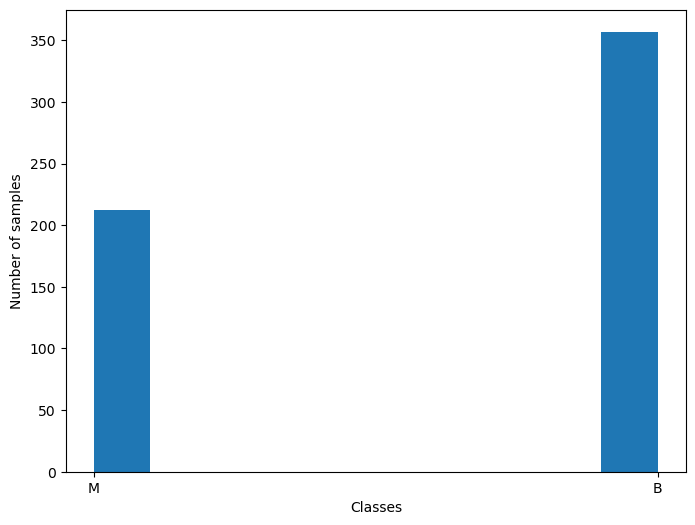

In [7]:
figure(figsize = (8, 6))
hist(data.Class)
xlabel("Classes")
ylabel("Number of samples")

savefig("./plots/4.12.1.png")

### Inspecting the feature set

In [8]:
df = DataFrame(data)[:, 2:end];

Printing the 1st 10 rows so as to get a visual idea about the type of data we're dealing with

In [10]:
pprint(first(df[:, 1:6], 10))

10×6 DataFrame
 Row │ Class    mean radius  mean texture  mean perimeter  mean area  mean smoothness
     │ String1  Float64      Float64       Float64         Float64    Float64
─────┼────────────────────────────────────────────────────────────────────────────────
   1 │ M              17.99         10.38          122.8      1001.0          0.1184
   2 │ M              20.57         17.77          132.9      1326.0          0.08474
   3 │ M              19.69         21.25          130.0      1203.0          0.1096
   4 │ M              11.42         20.38           77.58      386.1          0.1425
   5 │ M              20.29         14.34          135.1      1297.0          0.1003
   6 │ M              12.45         15.7            82.57      477.1          0.1278
   7 │ M              18.25         19.98          119.6      1040.0          0.09463
   8 │ M              13.71         20.83           90.2       577.9          0.1189
   9 │ M              13.0          21.82           

For checking the statistical attributes of each individual feature, we can use the **describe()** method

In [11]:
pprint(describe(df))

31×7 DataFrame
 Row │ variable                 mean        min        median    max      nmissing  eltype
     │ Symbol                   Union…      Any        Union…    Any      Int64     DataType
─────┼───────────────────────────────────────────────────────────────────────────────────────
   1 │ Class                                B                    M               0  String1
   2 │ mean radius              14.1273     6.981      13.37     28.11           0  Float64
   3 │ mean texture             19.2896     9.71       18.84     39.28           0  Float64
   4 │ mean perimeter           91.969      43.79      86.24     188.5           0  Float64
   5 │ mean area                654.889     143.5      551.1     2501.0          0  Float64
   6 │ mean smoothness          0.0963603   0.05263    0.09587   0.1634          0  Float64
   7 │ mean compactness         0.104341    0.01938    0.09263   0.3454          0  Float64
   8 │ mean concavity           0.0887993   0.0        0.06154 

As we can see the feature set consists of varying features that have different ranges and quantiles. This can cause trouble for the optimization techniques and might cause convergence issues. We can use a feature scaling technique like **Standardizer()** to handle this.

But first, let's handle the scientific types of all the features. We can use the schema() method from MLJ.jl package to do this

In [12]:
pprint(schema(df))

ScientificTypes.Schema{(:Class, Symbol("mean radius"), Symbol("mean texture"), Symbol("mean perimeter"), Symbol("mean area"), Symbol("mean smoothness"), Symbol("mean compactness"), Symbol("mean concavity"), Symbol("mean concave points"), Symbol("mean symmetry"), Symbol("mean fractal dimension"), Symbol("radius error"), Symbol("texture error"), Symbol("perimeter error"), Symbol("area error"), Symbol("smoothness error"), Symbol("compactness error"), Symbol("concavity error"), Symbol("concave points error"), Symbol("symmetry error"), Symbol("fractal dimension error"), Symbol("worst radius"), Symbol("worst texture"), Symbol("worst perimeter"), Symbol("worst area"), Symbol("worst smoothness"), Symbol("worst compactness"), Symbol("worst concavity"), Symbol("worst concave points"), Symbol("worst symmetry"), Symbol("worst fractal dimension")), Tuple{Textual, Continuous, Continuous, Continuous, Continuous, Continuous, Continuous, Continuous, Continuous, Continuous, Continuous, Continuous, Conti

As the target variable is 'Textual' in nature, we'll have to change it to a more appropriate scientific type. Using the **coerce()** method, let's change it to an `OrderedFactor`.

In [13]:
coerce!(df, :Class => OrderedFactor{2});

### Unpacking the values

---

Now that our data is fully processed, we can seperate the target variable 'y' from the feature set 'X' using the **unpack()** method.

In [14]:
y, X = unpack(df, ==(:Class), name -> true, rng = RANDOM_SEED);

### Standardizing the "feature set"

---

Now that our feature set is seperated from the target variable, we can use the **Standardizer()** workflow to obtain to standardize our feature set 'X'.

In [15]:
transformer_instance = Standardizer()
transformer_model = machine(transformer_instance, X)
fit!(transformer_model)
X = MLJ.transform(transformer_model, X)

┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness
,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.223405,-0.797401,-0.225484,-0.383301,0.813397,0.930817
2,-0.708643,2.3251,-0.703693,-0.681385,-0.198397,-0.352206
3,-0.549735,-1.39493,-0.530435,-0.565732,0.728073,-0.175166
4,0.945704,4.6478,0.88197,0.755045,0.125121,0.482062
5,0.605187,0.602262,0.639161,0.488502,1.43199,0.45366
6,1.60971,0.527862,1.55278,1.63424,-0.17991,0.49721
7,-0.450417,-0.69045,-0.441131,-0.507479,1.38222,0.0787502
8,0.741394,0.534837,0.746162,0.609839,-0.0185067,0.554014
9,-0.243269,-0.527698,-0.305323,-0.308283,-0.846855,-1.03007


### Train-test split

---

After feature scaling, our data is ready to put into a Machine Learning model for classificatoin! Using 80% of data for training, we can perform a train-set split using the **partition()** method.

In [17]:
train, test = partition(eachindex(y), 0.8, shuffle = true, rng = RANDOM_SEED);

### Model compatibility

---

Now that we have seperate training and testing set, let's see the models compatible with our data!

In [18]:
for m in models(matching(X, y))
    println("Model name = ", m.name,  ", ", 
             "Prediction type = ", m.prediction_type, ", ",
             "Package name = ", m.package_name);
end

Model name = AdaBoostClassifier, Prediction type = probabilistic, Package name = ScikitLearn
Model name = AdaBoostStumpClassifier, Prediction type = probabilistic, Package name = DecisionTree
Model name = BaggingClassifier, Prediction type = probabilistic, Package name = ScikitLearn
Model name = BayesianLDA, Prediction type = probabilistic, Package name = MultivariateStats
Model name = BayesianLDA, Prediction type = probabilistic, Package name = ScikitLearn
Model name = BayesianQDA, Prediction type = probabilistic, Package name = ScikitLearn
Model name = BayesianSubspaceLDA, Prediction type = probabilistic, Package name = MultivariateStats
Model name = ConstantClassifier, Prediction type = probabilistic, Package name = MLJModels
Model name = DSADDetector, Prediction type = unknown, Package name = OutlierDetectionNetworks
Model name = DecisionTreeClassifier, Prediction type = probabilistic, Package name = BetaML
Model name = DecisionTreeClassifier, Prediction type = probabilistic, Packa

### Analyzing the performance of different models

---

That's a lot of models for our data! To narrow it down, let's analyze the performance of "probabilistic classifiers" from the "ScikitLearn" package.

### Creating various empty vectors for our analysis

* **model_names** captures the names of the models being iterated 

* **loss_acc captures** the value of the model accuracy on the test set

* **loss_ce captures** the values of the Cross-entropy loss on the test set

* **loss_f1** captures the values of F1-Score on the test set

In [19]:
model_names = Vector{String}();
loss_acc=[];
loss_ce=[];
loss_f1=[];

### Collecting data for analysis

import MLJScikitLearnInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168
┌ Info: Training Machine{AdaBoostClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


import MLJScikitLearnInterface ✔
import MLJScikitLearnInterface ✔
import MLJScikitLearnInterface ✔
import MLJScikitLearnInterface ✔
import MLJScikitLearnInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168
┌ Info: Training Machine{BaggingClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168
┌ Info: Training Machine{BayesianLDA,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168
┌ Info: Training Machine{BayesianQDA,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168
┌ Info: Training Machine{DummyClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Fo

import MLJScikitLearnInterface ✔
import MLJScikitLearnInterface ✔
import MLJScikitLearnInterface ✔


C:\Users\jeffr\.julia\conda\3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168
┌ Info: Training Machine{GaussianNBClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168
┌ Info: Training Machine{GaussianProcessClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


import MLJScikitLearnInterface ✔
import MLJScikitLearnInterface ✔
import MLJScikitLearnInterface ✔
import MLJScikitLearnInterface ✔


┌ Info: Training Machine{GradientBoostingClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
C:\Users\jeffr\.julia\conda\3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168
┌ Info: Training Machine{KNeighborsClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168
┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJMode

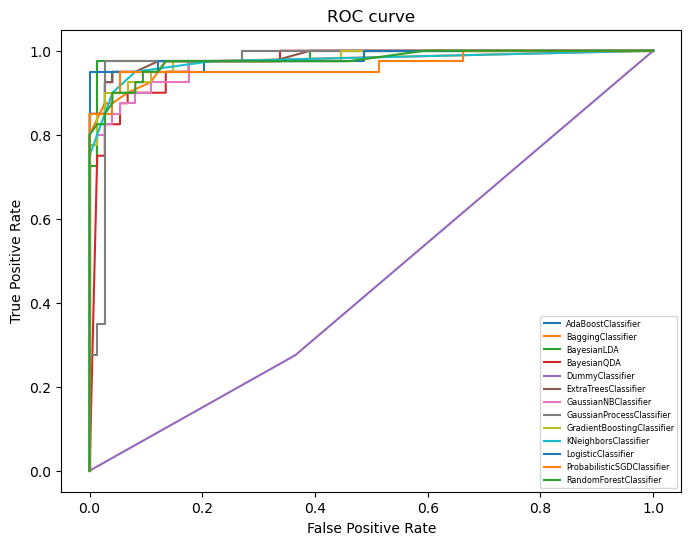

In [23]:
figure(figsize=(8, 6))
for m in models(matching(X, y))
    if m.prediction_type==Symbol("probabilistic") && m.package_name=="ScikitLearn" && m.name!="LogisticCVClassifier"
        #Excluding LogisticCVClassfiier as we can infer similar baseline results from the LogisticClassifier

        #Capturing the model and loading it using the @load utility
        model_name=m.name
        package_name=m.package_name
        eval(:(clf = @load $model_name pkg=$package_name verbosity=1))

        #Fitting the captured model onto the training set
        clf_machine = machine(clf(), X, y)
        fit!(clf_machine, rows=train)

        #Getting the predictions onto the test set
        y_pred = MLJ.predict(clf_machine, rows=test);

        #Plotting the ROC-AUC curve for each model being iterated
        fprs, tprs, thresholds = roc(y_pred, y[test])
        plot(fprs, tprs,label=model_name);

        #Obtaining different evaluation metrics
        ce_loss = mean(cross_entropy(y_pred,y[test]))
        acc = accuracy(mode.(y_pred), y[test])
        f1_score = f1score(mode.(y_pred), y[test])

        #Adding the different obtained values of the evaluation metrics to the respective vectors
        push!(model_names, m.name)
        append!(loss_acc, acc)
        append!(loss_ce, ce_loss)
        append!(loss_f1, f1_score)
    end
end

#Adding labels and legend to the ROC-AUC curve
xlabel("False Positive Rate")
ylabel("True Positive Rate")
legend(loc="best", fontsize="xx-small")
title("ROC curve")

savefig("./plots/4.12.2.png")

### Analyzing models

Let's collect the data in form a dataframe for a more precise analysis

In [24]:
model_info = DataFrame(ModelName = model_names, Accuracy = loss_acc, CrossEntropyLoss = loss_ce, F1Score = loss_f1);

Now, let's sort the data on basis of the Cross-entropy loss

In [25]:
pprint(sort!(model_info, [:CrossEntropyLoss]));

26×4 DataFrame
 Row │ ModelName                   Accuracy  CrossEntropyLoss  F1Score
     │ String                      Any       Any               Any
─────┼──────────────────────────────────────────────────────────────────
   1 │ LogisticClassifier          0.973684  0.13142           0.962025
   2 │ LogisticClassifier          0.973684  0.13142           0.962025
   3 │ BayesianLDA                 0.95614   0.145701          0.935065
   4 │ BayesianLDA                 0.95614   0.145701          0.935065
   5 │ ExtraTreesClassifier        0.938596  0.149944          0.909091
   6 │ RandomForestClassifier      0.938596  0.158374          0.911392
   7 │ ExtraTreesClassifier        0.938596  0.164727          0.911392
   8 │ RandomForestClassifier      0.938596  0.174436          0.911392
   9 │ GradientBoostingClassifier  0.929825  0.232854          0.894737
  10 │ GradientBoostingClassifier  0.938596  0.239695          0.909091
  11 │ AdaBoostClassifier          0.95614   0.3495   

It seems like a simple LogisticClassifier works really well with this dataset!

### Conclusion 

---

This article covered iterative feature selection on the Breast cancer classification dataset.
In this tutorial, we only analyze the **ScikitLearn** models so as to keep the flow of the content precise, but the sampe workflow can be applied to any compatible model in **MLJ** family.